<a href="https://colab.research.google.com/github/FIKENYE/Personal-Projects/blob/main/AI_bubble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance

Fetching data for ['NVDA', 'MSFT', 'PLTR', 'AMD', 'GOOGL']...


/tmp/ipython-input-950887487.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=datetime.now() - timedelta(days=730), progress=False)['Close']


Current Daily Volatility: 0.0211
Starting 1 Million Simulations... Goodnight.
Simulation Complete. Image saved as 'ai_bubble_test.png'


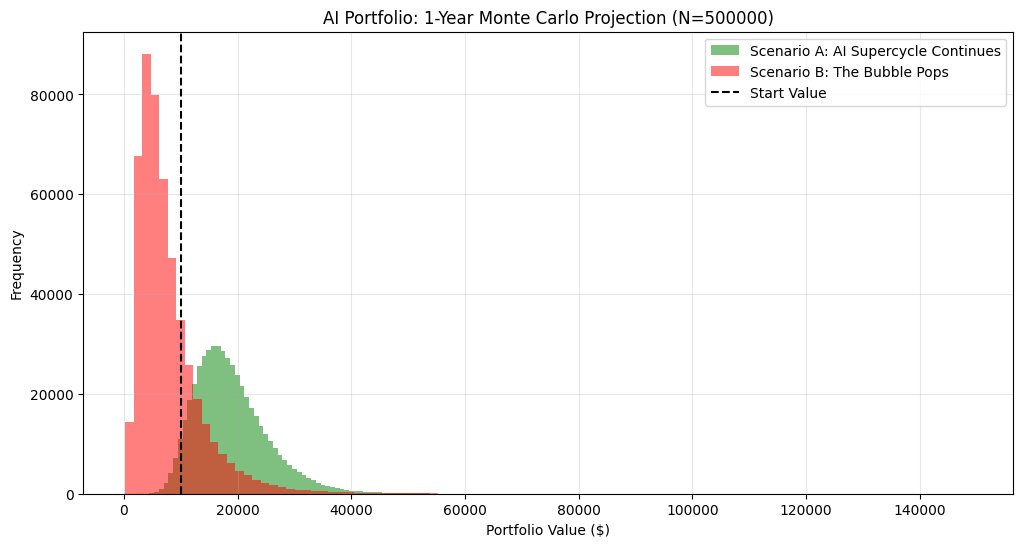

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# --- 1. CONFIGURATION ---
tickers = ['NVDA', 'MSFT', 'PLTR', 'AMD', 'GOOGL']
weights = np.array([0.2, 0.2, 0.2, 0.2, 0.2]) # Equal weight
initial_portfolio = 10000 # Starting with $10k
simulations = 500000 # The "Sleep" Number (1 Million runs)
time_horizon = 252 # Trading days in 1 year

# --- 2. GET DATA ---
print(f"Fetching data for {tickers}...")
# Get last 2 years of data to capture the 'AI Boom' volatility
data = yf.download(tickers, start=datetime.now() - timedelta(days=730), progress=False)['Close']

# Calculate Daily Returns
returns = data.pct_change().dropna()

# Calculate Portfolio Metrics (The "AI Supercycle" Stats)
# We assume the portfolio acts as one unit for simplicity here
port_returns = returns.dot(weights)
mean_return = port_returns.mean()
volatility = port_returns.std()

print(f"Current Daily Volatility: {volatility:.4f}")
print(f"Starting 1 Million Simulations... Goodnight.")

# --- 3. MONTE CARLO ENGINE ---

# Scenario A: "Status Quo" (Based on recent history)
# We use NumPy's vectorized operations for speed, but 1M sims will still crunch.
# Formula: Last_Price * exp((Mean - 0.5 * Vol^2) * dt + Vol * Z)
dt = 1 # 1 day steps
daily_drift = mean_return - 0.5 * volatility**2

# Generate random shocks for all paths at once (Sims x Days)
# This is a massive matrix (1,000,000 x 252).
# If you run out of RAM, reduce simulations to 100,000.
random_shocks = np.random.normal(0, 1, (simulations, time_horizon))

# Calculate cumulative returns path
# This creates the "Cone" of price movement
log_returns = daily_drift + volatility * random_shocks
cumulative_returns = np.exp(np.cumsum(log_returns, axis=1))

# Apply to initial portfolio value
# We only care about the END value for the histogram
final_values = initial_portfolio * cumulative_returns[:, -1]

# --- 4. THE "BUBBLE POP" STRESS TEST ---
# To test a bubble, we simulate what happens if Drift turns negative
# and Volatility doubles (Panic mode).
crash_drift = -0.001 # Slightly negative daily drift (approx -20% / year)
crash_vol = volatility * 2.0 # Panic volatility

# Generate Crash paths
log_returns_crash = (crash_drift - 0.5 * crash_vol**2) + crash_vol * random_shocks
final_values_crash = initial_portfolio * np.exp(np.sum(log_returns_crash, axis=1))

# --- 5. VISUALIZATION & SAVING ---
plt.figure(figsize=(12, 6))

# Plot Histogram of "Status Quo"
plt.hist(final_values, bins=100, alpha=0.5, color='green', label='Scenario A: AI Supercycle Continues')

# Plot Histogram of "Bubble Pop"
plt.hist(final_values_crash, bins=100, alpha=0.5, color='red', label='Scenario B: The Bubble Pops')

plt.axvline(initial_portfolio, color='k', linestyle='--', label='Start Value')
plt.title(f'AI Portfolio: 1-Year Monte Carlo Projection (N={simulations})')
plt.xlabel('Portfolio Value ($)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)

# SAVE THE RESULT so you can see it tomorrow
plt.savefig('ai_bubble_test.png')
print("Simulation Complete. Image saved as 'ai_bubble_test.png'")

# --- 6. QUANT STATS ---
# Calculate Value at Risk (95% Confidence)
var_95_normal = np.percentile(final_values, 5)
var_95_crash = np.percentile(final_values_crash, 5)

with open('simulation_results.txt', 'w') as f:
    f.write(f"--- AI BUBBLE TEST RESULTS ---\n")
    f.write(f"Initial Investment: ${initial_portfolio}\n")
    f.write(f"Simulations Run: {simulations}\n\n")

    f.write(f"SCENARIO A (Current Trend):\n")
    f.write(f"Worst 5% Case (VaR 95): Portfolio drops to ${var_95_normal:.2f}\n")
    f.write(f"Chance of losing money: {np.mean(final_values < initial_portfolio)*100:.2f}%\n\n")

    f.write(f"SCENARIO B (Bubble Pop):\n")
    f.write(f"Worst 5% Case (VaR 95): Portfolio drops to ${var_95_crash:.2f}\n")
    f.write(f"Chance of losing money: {np.mean(final_values_crash < initial_portfolio)*100:.2f}%\n")

Robustness Plot saved as 'ai_robustness_check.png'

--- ROBUSTNESS METRICS ---
Average Max Drawdown: -20.61%
Worst 5% Drawdown Limit: -33.63%
(If this is > 50%, you will likely panic sell before the year ends)
------------------------------
VaR (95%): $10271.97 (The edge of the cliff)
CVaR (95%): $9000.09 (The bottom of the canyon)
Difference: $1271.89 (This is your hidden tail risk)


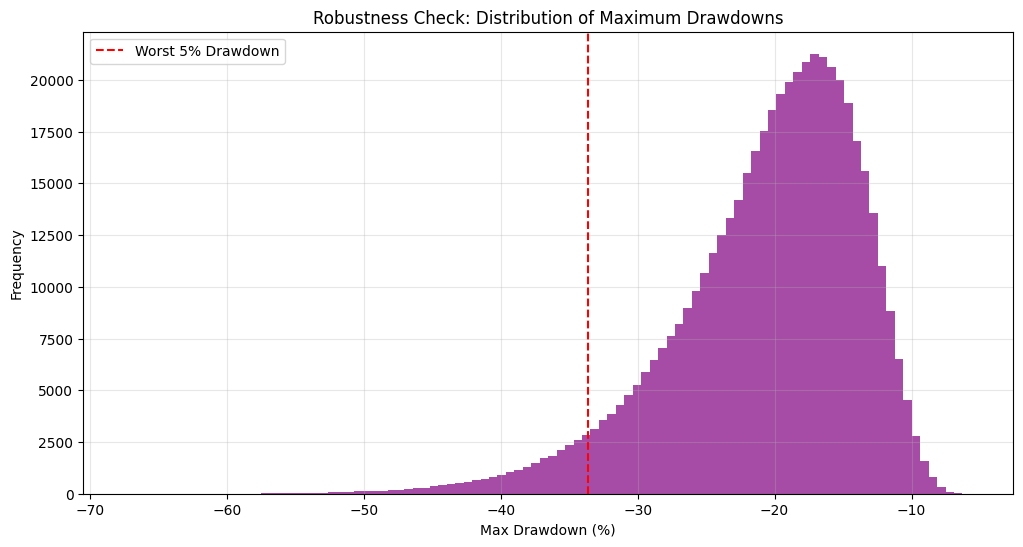

In [ ]:
# --- ROBUSTNESS TESTS ---

# 1. CALCULATE MAXIMUM DRAWDOWN (MDD)
# We need to find the peak-to-trough drop for EVERY single simulation path.
# This is vectorised, so it's fast.

# Calculate the running maximum for every path over time
running_max = np.maximum.accumulate(cumulative_returns, axis=1)
running_max[running_max < 1] = 1 # Avoid division by zero issues if it starts at 1

# Calculate drawdown percentage at every step
drawdown = (cumulative_returns - running_max) / running_max

# Find the MAXIMUM drawdown for each path (the worst drop in that year)
max_drawdowns = np.min(drawdown, axis=1) # It's negative, so min is the deepest hole

# 2. CALCULATE CVaR (Expected Shortfall)
# Filter for the worst 5% of outcomes
worst_5_percent_cutoff = np.percentile(final_values, 5)
worst_outcomes = final_values[final_values < worst_5_percent_cutoff]
cvar_95 = worst_outcomes.mean()

# --- VISUALISING ROBUSTNESS ---
plt.figure(figsize=(12, 6))

# Histogram of Max Drawdowns
plt.hist(max_drawdowns * 100, bins=100, color='purple', alpha=0.7)
plt.title('Robustness Check: Distribution of Maximum Drawdowns')
plt.xlabel('Max Drawdown (%)')
plt.ylabel('Frequency')
plt.axvline(np.percentile(max_drawdowns, 5) * 100, color='r', linestyle='--', label='Worst 5% Drawdown')
plt.legend()
plt.grid(True, alpha=0.3)

# Save robustness check
plt.savefig('ai_robustness_check.png')
print("Robustness Plot saved as 'ai_robustness_check.png'")

# --- PRINT STATS ---
print("\n--- ROBUSTNESS METRICS ---")
print(f"Average Max Drawdown: {max_drawdowns.mean()*100:.2f}%")
print(f"Worst 5% Drawdown Limit: {np.percentile(max_drawdowns, 5)*100:.2f}%")
print(f"(If this is > 50%, you will likely panic sell before the year ends)")
print("-" * 30)
print(f"VaR (95%): ${var_95_normal:.2f} (The edge of the cliff)")
print(f"CVaR (95%): ${cvar_95:.2f} (The bottom of the canyon)")
print(f"Difference: ${var_95_normal - cvar_95:.2f} (This is your hidden tail risk)")